In [15]:
import numpy as np
import csv
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
from IPython.core.display import HTML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
book_data = pd.read_csv('./books.csv')
print(book_data.shape)
book_data.head(10)

(6810, 12)


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0
6,9780006353287,0006353282,An Autobiography,NaN,Agatha Christie,"Authors, English",http://books.google.com/books/content?id=c49GQ...,Donation.,1977.0,4.27,560.0,3975.0
7,9780006380832,0006380832,Empires of the Monsoon,A History of the Indian Ocean and Its Invaders,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0
8,9780006470229,000647022X,The Gap Into Madness,Chaos and Order,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0
9,9780006472612,0006472613,Master of the Game,NaN,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0


# Cleaning

In [17]:
book_data.count()

isbn13            6810
isbn10            6810
title             6810
subtitle          2381
authors           6738
categories        6711
thumbnail         6481
description       6548
published_year    6804
average_rating    6767
num_pages         6767
ratings_count     6767
dtype: int64

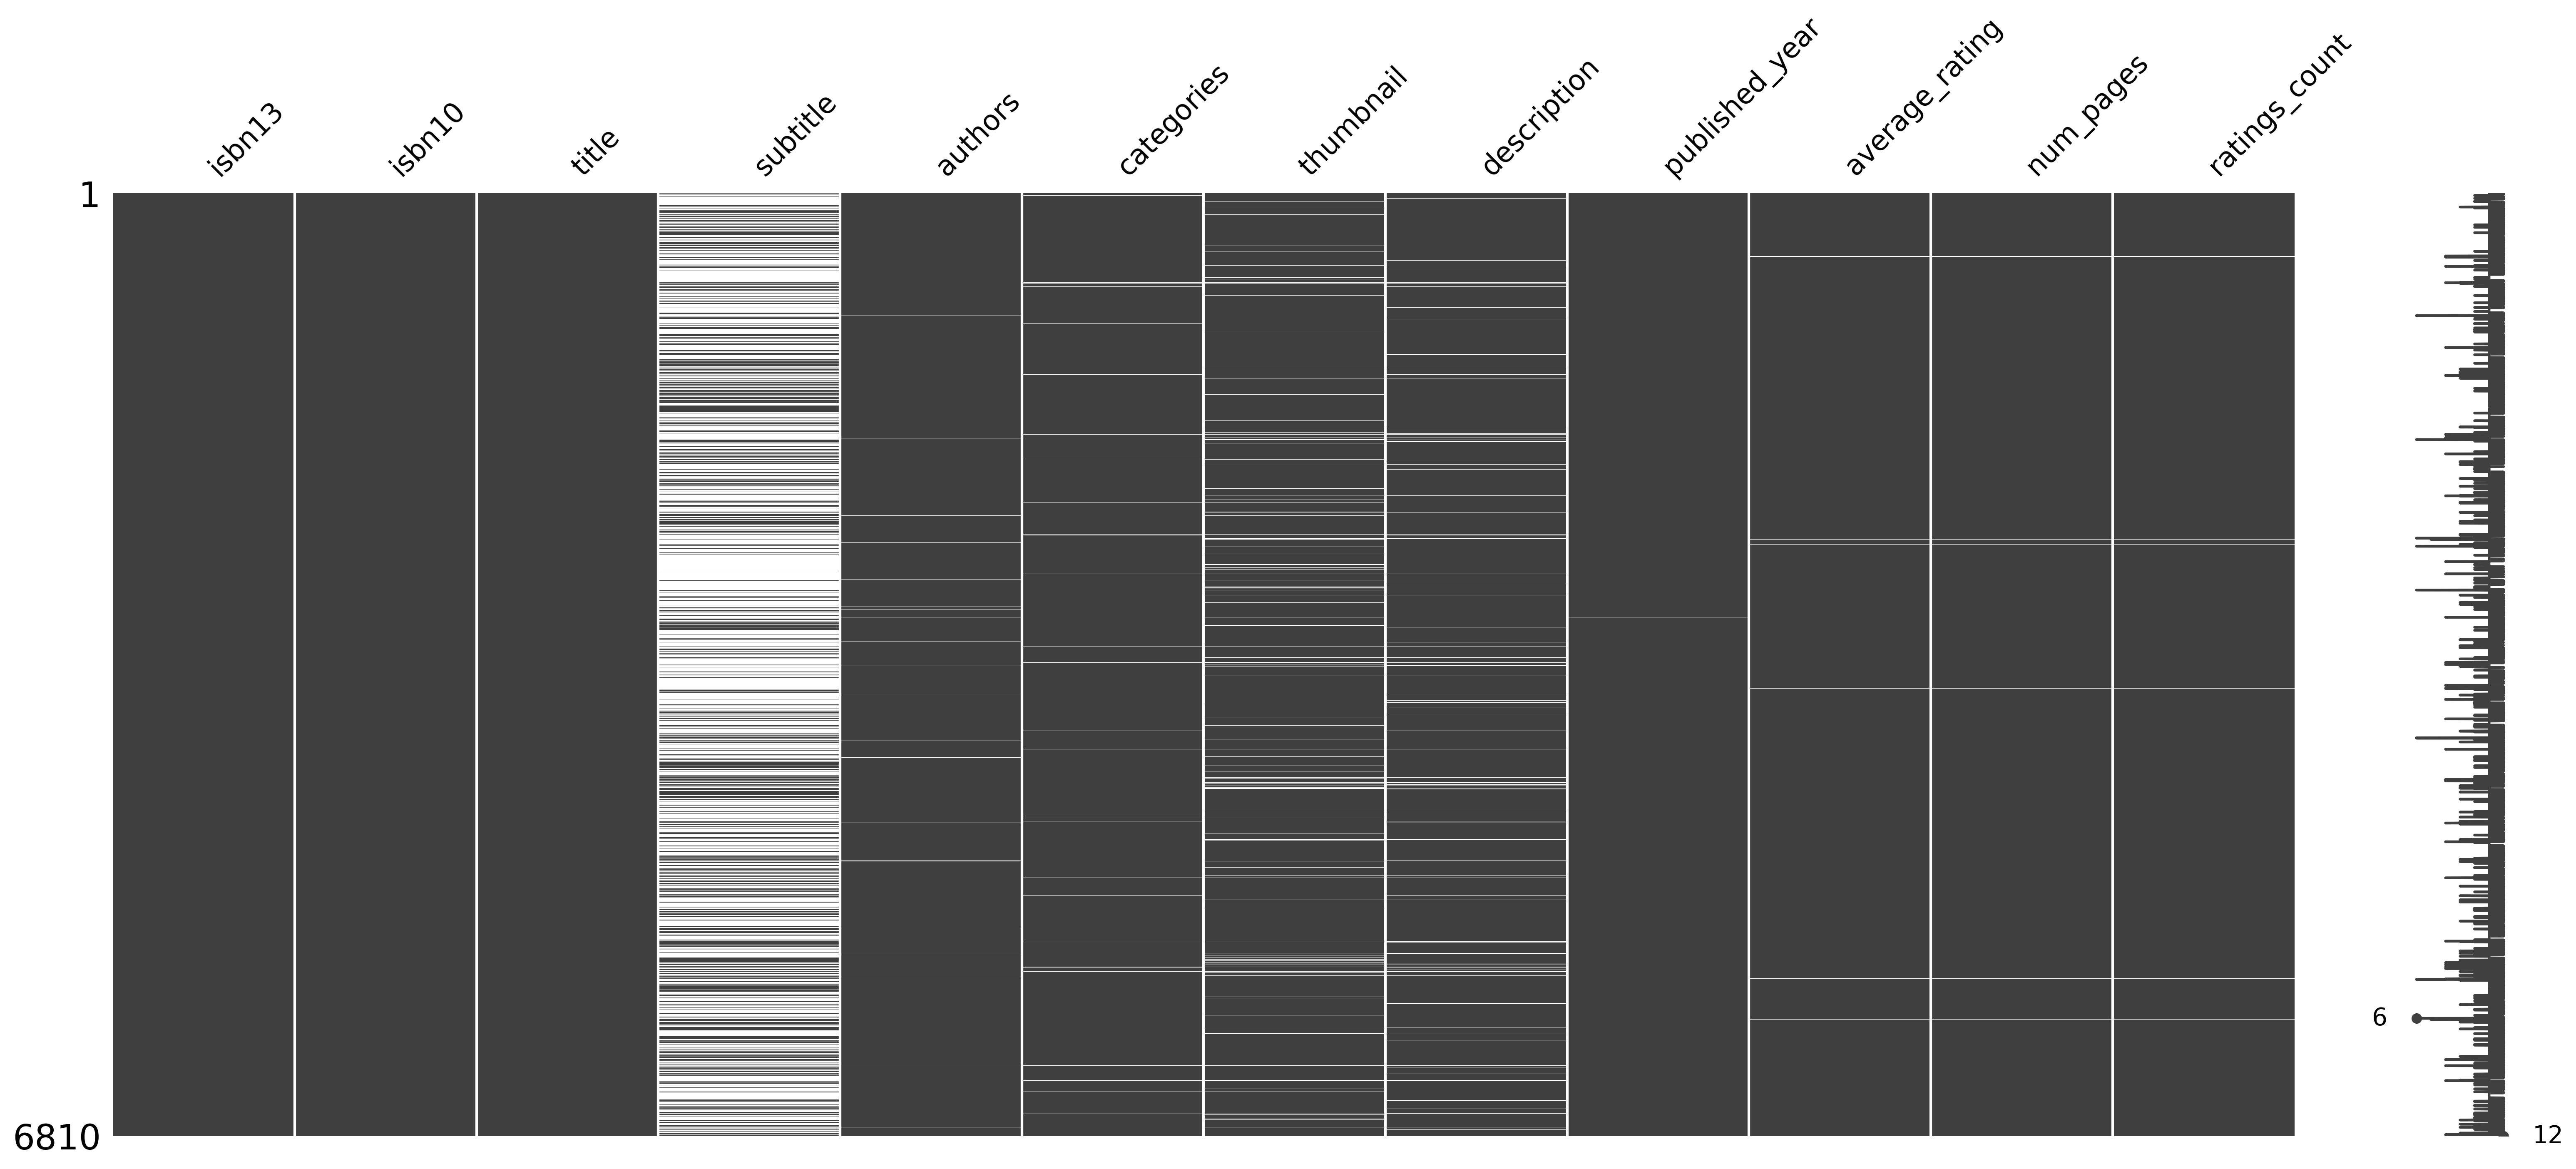

In [18]:
msno.matrix(book_data)
plt.show()

In [19]:
book_data = book_data[book_data['average_rating'].notna()]
book_data = book_data[book_data['num_pages'].notna()]
book_data = book_data[book_data['ratings_count'].notna()]
book_data = book_data[book_data['published_year'].notna()]
book_data = book_data.replace(np.nan, '', regex=True)
book_data.count()

isbn13            6762
isbn10            6762
title             6762
subtitle          6762
authors           6762
categories        6762
thumbnail         6762
description       6762
published_year    6762
average_rating    6762
num_pages         6762
ratings_count     6762
dtype: int64

# Basic Analysis

## Top 10 categories

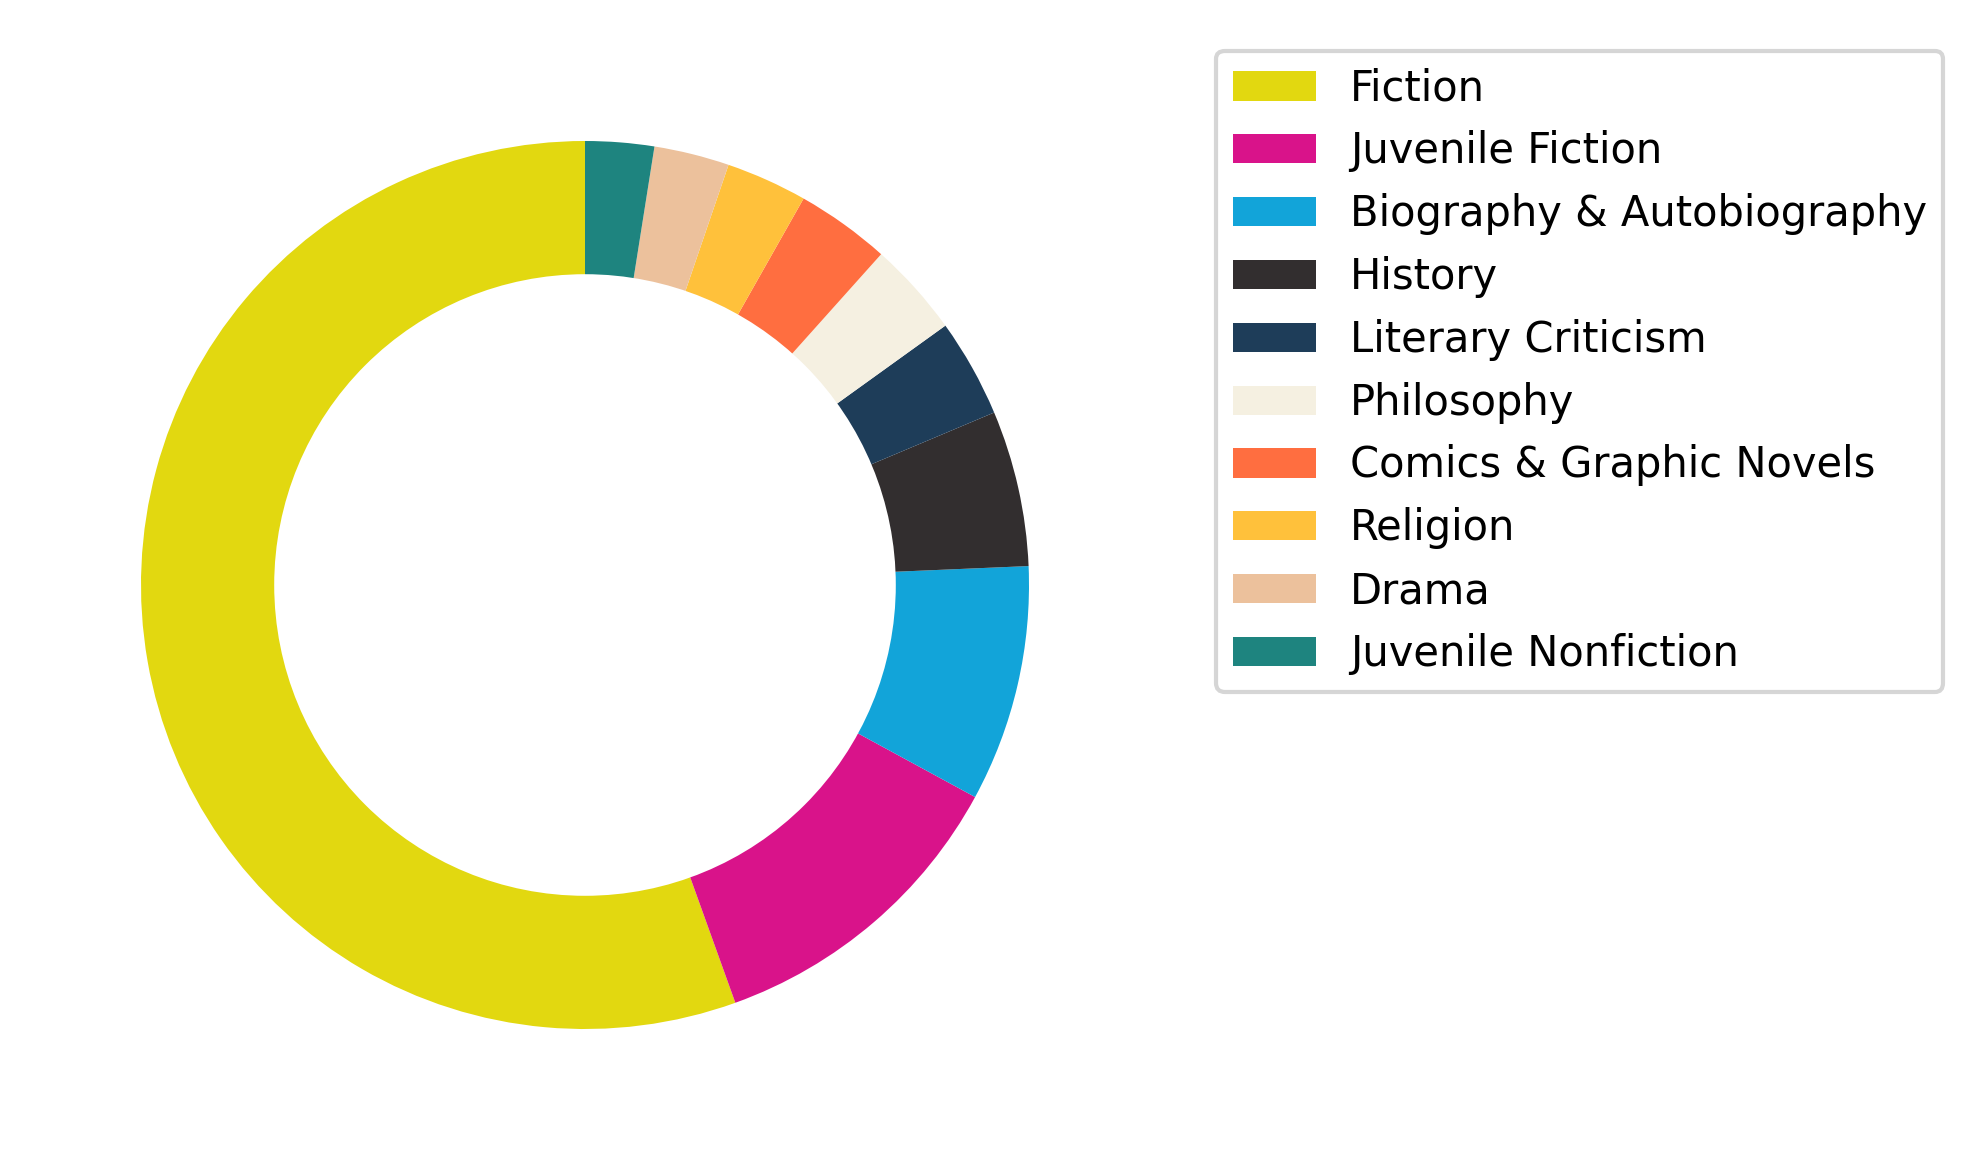

In [20]:
mpl.rcParams['figure.dpi'] = 300
top_10 = book_data['categories'].value_counts()[:10]
colors = ['#e2d810', '#d9138a', '#12a4d9', '#322e2f','#1e3d59', '#f5f0e1', '#ff6e40', '#ffc13b','#ecc19c', '#1e847f']
patches, texts = plt.pie(top_10,colors = colors,startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(patches, top_10.index, loc='upper left',bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Top 50 popular and good rated books

In [21]:
pop_ratings_df = book_data.copy()
pop_ratings_df['popularity_rating'] = book_data.average_rating*book_data.ratings_count
pop_ratings_df = pop_ratings_df.sort_values(by = ['popularity_rating'], ascending = False)[0:50]
def path_to_image_html(path):
    return '<img src="'+ path + '" width="200" >'
del pop_ratings_df['popularity_rating']
del pop_ratings_df['description']
HTML(pop_ratings_df.to_html(escape=False,formatters=dict(thumbnail=path_to_image_html)))

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,published_year,average_rating,num_pages,ratings_count
2698,9780439554930,0439554934,Harry Potter and the Sorcerer's Stone (Book 1),,"Rowling, J.K.",Juvenile Fiction,,2015.0,4.47,320.0,5629932.0
1643,9780316015844,0316015849,Twilight,,Stephenie Meyer,Young Adult Fiction,,2006.0,3.59,498.0,4367341.0
3741,9780618260300,0618260307,"The Hobbit, Or, There and Back Again",,John Ronald Reuel Tolkien,Juvenile Fiction,,2001.0,4.26,366.0,2364968.0
2710,9780439655484,043965548X,Harry Potter and the Prisoner of Azkaban (Book 3),,"Rowling, J.K.",Juvenile Fiction,,2015.0,4.55,435.0,2149872.0
2661,9780439064866,0439064864,Harry Potter and the Chamber of Secrets (Book 2),,"Rowling, J.K.",Juvenile Fiction,,2015.0,4.41,341.0,2115562.0
2676,9780439358071,0439358078,Harry Potter and the Order of the Phoenix (Book 5),,"Rowling, J.K.",Juvenile Fiction,,2015.0,4.49,870.0,1996446.0
2723,9780439785969,0439785960,Harry Potter and the Half-Blood Prince (Book 6),,"Rowling, J.K.",Juvenile Fiction,,2015.0,4.56,652.0,1944099.0
5898,9781416524793,1416524797,Angels & Demons,,Dan Brown,Fiction,,2006.0,3.88,736.0,2279854.0
3745,9780618346257,0618346252,The Fellowship of the Ring,Being the First Part of the Lord of the Rings,J. R. R. Tolkien,Fiction,,2003.0,4.35,398.0,2009749.0
738,9780140283334,0140283331,Lord of the Flies,,William Golding,Fiction,,1999.0,3.67,182.0,1861140.0


# Recommendation

## Content-based recommendation

In [22]:
book_data['features'] = book_data['description']+' '+ book_data['categories']+' '+book_data['authors']
book_data['features'].head()

0    A NOVEL THAT READERS and critics have been eag...
1    A new 'Christie for Christmas' -- a full-lengt...
2    Volume Two of Stephen Donaldson's acclaimed se...
3    A memorable, mesmerizing heroine Jennifer -- b...
4    Lewis' work on the nature of love divides love...
Name: features, dtype: object

In [23]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(book_data["features"])
print(count_matrix)

  (0, 20348)	1
  (0, 29119)	2
  (0, 23753)	2
  (0, 1597)	13
  (0, 7150)	2
  (0, 13417)	1
  (0, 3169)	1
  (0, 9294)	1
  (0, 1789)	1
  (0, 11560)	4
  (0, 21032)	1
  (0, 7710)	1
  (0, 12390)	4
  (0, 15468)	6
  (0, 1546)	3
  (0, 2333)	1
  (0, 14550)	1
  (0, 27888)	3
  (0, 20579)	9
  (0, 24234)	1
  (0, 17313)	1
  (0, 15812)	4
  (0, 1499)	4
  (0, 22592)	2
  (0, 29124)	13
  :	:
  (6760, 21947)	1
  (6760, 15211)	1
  (6760, 25065)	1
  (6761, 1597)	1
  (6761, 15468)	1
  (6761, 20579)	3
  (6761, 11877)	1
  (6761, 28312)	1
  (6761, 29244)	1
  (6761, 2542)	1
  (6761, 6039)	1
  (6761, 10246)	1
  (6761, 17288)	1
  (6761, 12926)	1
  (6761, 29392)	1
  (6761, 7145)	1
  (6761, 14149)	1
  (6761, 25652)	1
  (6761, 32135)	1
  (6761, 11239)	1
  (6761, 32015)	1
  (6761, 13592)	1
  (6761, 24669)	1
  (6761, 15893)	1
  (6761, 12857)	1


In [24]:
cosine_sim = cosine_similarity(count_matrix)

In [25]:
book_user_likes = "The Kite Runner"
book_index = book_data.loc[book_data['title'] == book_user_likes].index[0]
book_index

6420

In [26]:
similar_books = list(enumerate(cosine_sim[book_index]))
similar_books[0:10]

[(0, 0.38368886787517353),
 (1, 0.45269135142543193),
 (2, 0.07037911332728822),
 (3, 0.32920394655217095),
 (4, 0.3015552103442833),
 (5, 0.34354335689363863),
 (6, 0.0),
 (7, 0.37052067103646796),
 (8, 0.3108317202687318),
 (9, 0.22568628174911476)]

In [27]:
#sorting
sorted_similar_books = sorted(similar_books,key=lambda x:x[1],reverse=True)

In [28]:
#printing
i=0
for element in sorted_similar_books:
		print(book_data.loc[element[0],"title"])
		i=i+1
		if i>50:
			break

The Kite Runner
The Portrait
Cat Cross Their Graves
Well of Darkness
The Sgt. Rock Archives
Finders Keepers
The Nubian Prince
The Franklin Affair
The Lure of the Basilisk
Hitty Her First Hundred Years
Limitations
Open House
Shade's Children (rack)
The Dark Mirror
Candy Licker
The Rum Diary
The Secret on Ararat
Harry Potter and the Prisoner of Azkaban
Them
A Fistful of Charms
The Game
No Place Like Home
Cryptonomicon
Aeschylus, 2
The New York Stories of Henry James
Firefly
Euripides, 3
To Kill a Mockingbird (slipcased edition)
Spider's Web
Silos, Politics and Turf Wars
The Time of Our Singing
The Little Princesses
Z for Zachariah
Steppenwolf
The Second World War
Best Science Fiction Stories of Clifford D. Simak
The Wheel of Life
Cat Breaking Free
By Slanderous Tongues
Controversy Creates Cash
Robert Ludlum's The Moscow Vector
Reading the Bible Again for the First Time
Ghost Story
Writings, 1902-1910
Counting Christmas
Little Miss Bad
Sophocles: the Theban Plays
Thus Spake the Corpse
Int